In [1]:
from __future__ import division
import sys
import argparse
import numpy as np
import pretty_midi
import librosa

See Pretty-Midi documentation http://craffel.github.io/pretty-midi/

(128, 200)


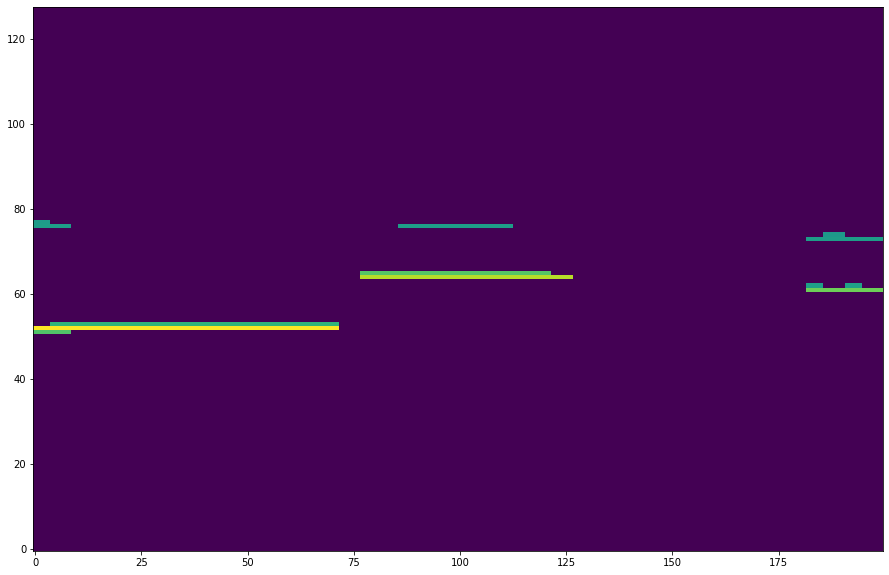

In [15]:
f = "sample.mid"
midi_data = pretty_midi.PrettyMIDI(f)
fs = 200 #midi sampling frequency
piano_matrix = midi_data.get_piano_roll(fs=200)

import numpy as np
print(np.shape(piano_matrix))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.imshow(piano_matrix[:,:1000], origin="lower")

In [20]:
midi_data

In [2]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.

    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.

    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.

    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


In [3]:
def cqt_to_piano_roll(cqt, min_midi, max_midi, threshold):
    '''Convert a CQT spectrogram into a piano roll representation by
     thresholding scaled magnitudes.

    Parameters
    ----------
    cqt : np.ndarray, shape=(max_midi-min_midi,frames), dtype=complex64
        CQT spectrogram of audio.
    min_midi : int
        Minimum MIDI note to transcribe.
    max_midi : int
        Maximum MIDI note to transcribe.
    threshold : int
        Threshold value to activate note on event, 0-127

    Returns
    -------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll representation on audio.

    '''
    piano_roll = np.abs(cqt)
    piano_roll = np.digitize(piano_roll,
                             np.linspace(piano_roll.min(),
                                         piano_roll.max(),
                                         127))
    piano_roll[piano_roll < threshold] = 0
    piano_roll = np.pad(piano_roll,
                        [(128 - max_midi, min_midi), (0, 0)],
                        'constant')
    return piano_roll


In [6]:
# Replace sample.wav with your sound file
y, sr = librosa.load("sample.wav")

import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot(y)

In [7]:
import IPython.display as ipd
ipd.Audio(data=y, rate=sr)

In [11]:
# Set a threshold 0-127 to find the notes 
min_midi = 24 # Minimum MIDI note to transcribe
max_midi = 107 # Maximum MIDI note to transcribe
threshold = 64 # Threshold to activate note on event, 0-127

cqt = librosa.cqt(y, sr=sr, fmin=min_midi, n_bins=max_midi - min_midi)

See Librosa CQT documentation https://librosa.github.io/librosa/generated/librosa.core.cqt.html

In [12]:
# Call the appropriate function to translate cqt to piano roll
pr = cqt_to_piano_roll(cqt, min_midi, max_midi, threshold)

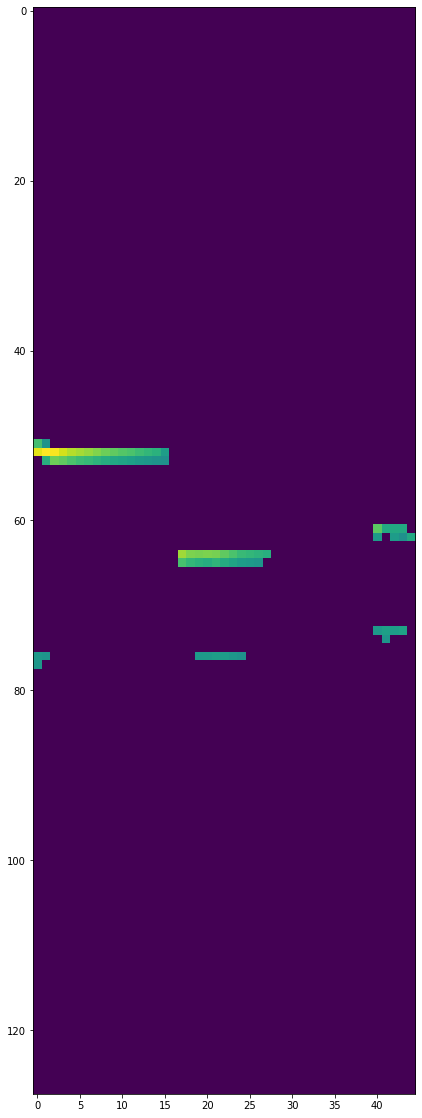

In [13]:
plt.figure(figsize=(10,20))
plt.imshow(pr)

In [14]:
# get audio time
# Hint: use len(y) to determine the number of samples is y and use sampling rate sr to determine how long y lasts in seconds
## --- WRITE YOUR EQUATION HERE
# audio_time = 

In [17]:
# get sampling frequency for midi reconstruction from cqt spectrogram
# Hint: use the shape of the pianoroll relative to audio time to determine the midi sampling frequency
## --- WRITE YOUR EQUATION HERE
# fs = 
pm = piano_roll_to_pretty_midi(pr, fs=fs,program=0)
pm.write("samplewav_to_midi.mid")

Download the midi result "samplewav_to_mid.mid" and open it in a midi editor, such as MuseScore

Open sample.mid in midi editor and play sample.wav on your computer
### Questions: 
1. Why did we use CQT?
2. How sample.mid amd samplewav_to_mid.mid compare?
3. What needs to be done to improve the result?

